In [3]:
# Hap3D
'''
Difference in RBM3 and CTPS2 
'''

'\nDifference in RBM3 and UBA1\n'

In [4]:
import pandas as pd
import numpy as np
import math
import datatable as dt
import gc
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_color_codes("pastel") # 颜色设定
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from sklearn.utils import resample
from scipy import stats
import pybedtools
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_rel
from pybedtools import BedTool
from scipy.stats import fisher_exact
from statsmodels.stats import multitest
import scipy.stats as stats

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams 
rcParams['pdf.fonttype'] = 42 # True font
rcParams['font.size'] =  8  
rcParams['grid.linewidth'] =  0.5 
rcParams['lines.color'] = 'b' 
rcParams['lines.linewidth'] = 1 
rcParams['lines.markersize'] = 3
rcParams['lines.markeredgewidth'] = 0 # set Marker with no edgelines
rcParams['axes.linewidth'] = 0.5
rcParams['axes.titlesize'] = 12
rcParams['axes.labelsize'] = 8
rcParams['xtick.labelsize'] = 8
rcParams['ytick.labelsize'] = 8
rcParams['legend.fontsize'] = 8
rcParams['legend.title_fontsize'] = 8

In [7]:
### laoding phasing fragments
Rawdir="/data2/linzhuobin/Hap3D_Figures/figure_processing_data/Fig6"
outdir = "/data2/linzhuobin/Hap3D_Figures/pdf"
filter_Frag =  5
region = ["chrX",0, 156040895]
fhap_list=f'{Rawdir}/fhap_list/chrX/frag-hap_mapq5.list' ## dip3d filter
fhap=pd.read_csv(fhap_list,header=None,sep='\t',names=['rID','fID','chrom','pos','hp'],
                usecols = [0,1,2,3,5])
fhap["chrom"] = "chrX"

### read-level phasing stats
read_df = fhap.groupby('rID')['hp'].apply(list).reset_index()
read_df['h1'] = read_df.hp.apply(lambda x: x.count(1) if 1 in x else 0)
read_df['h2'] = read_df.hp.apply(lambda x: x.count(2) if 2 in x else 0)
read_df['un'] = read_df.hp.apply(lambda x: x.count(0) if 0 in x else 0)
read_df['hp'] = read_df['h1'] + read_df['h2']
read_df['Fc'] = read_df['hp'] + read_df['un']
read_df['mod_fc'] = read_df.Fc.apply(lambda x: x if x<=10 else 10)
read_df['ratio'] = read_df.apply(lambda x: round(x.hp/x.Fc*100,2),axis=1)
##### read haplotype assign
read_df["HP"] = -1
P1 = read_df.h1 == read_df.hp
P2 = read_df.h2 == read_df.hp
P3 = read_df.ratio == 0
read_df.loc[P1, "HP"] = 1
read_df.loc[P2, "HP"] = 2
read_df.loc[P3, "HP"] = 0
Fragmentcount = read_df.set_index("rID").to_dict()['Fc'] # fragment count

In [8]:
# Filter hp reads
h1_reads = read_df.loc[read_df.HP==1, "rID"].values
h2_reads = read_df.loc[read_df.HP==2, "rID"].values
fhap["HP"] = 0
fhap.loc[fhap.rID.isin(h1_reads), "HP"] = 1
fhap.loc[fhap.rID.isin(h2_reads), "HP"] = 2
fhap_filter = fhap.loc[fhap.HP!=0, :].copy()
## filter fragment
freads = read_df.loc[read_df.Fc >= filter_Frag, "rID"].unique()
fhap_filter = fhap_filter.loc[ fhap_filter.rID.isin(freads), :]
freads = None

In [9]:
flanksize = 2500 # using flank size to calclate start and end
binsize = 5000
fhap_filter["start"] = fhap_filter["pos"] - flanksize
fhap_filter["end"] = fhap_filter["pos"] + flanksize
fhap_filter["bin"] = fhap_filter["pos"].values // binsize
fhap_filter["Fc"] = fhap_filter["rID"].apply(lambda x: Fragmentcount[x] )
fhap_filter = fhap_filter.loc[:, ["chrom", "start", "end", "rID", "fID", "Fc", "bin", "HP"]]

In [10]:
binVDF = fhap_filter

In [11]:
# Filter
def FilterDF(VDF_DF, region, filter_Frag):
    ## region filter
    print("Befor filter : %d"%len(VDF_DF))
    Pchr = VDF_DF.chrom == region[0]
    Pregion = (VDF_DF.start >= region[1]) & (VDF_DF.end <= region[2])
    VDF_filter = VDF_DF.loc[ Pchr & Pregion , :]
    print("After Region Filter: %d"%len(VDF_filter) )
    ## fragment filter
    #Fragmentcount = VDF_filter.groupby(by="read_name", as_index=True)["chrom"].count()
    Fragmentcount = {}
    rN = 0
    fIDlist = []
    for  n, rowval in VDF_filter.iterrows():
        read_name = rowval["read_name"]
        if read_name not in Fragmentcount :
            #rN = shorten_readname(read_name) # short readID
            rN = read_name
            fc = 1
            fN = 0
        else:
            rN, fc = Fragmentcount[read_name]
            fc += 1
        Fragmentcount[read_name] = (rN, fc)
        fIDlist.append(fN)
        fN += 1
    ### fragment ID
    Fragment_df = pd.DataFrame(Fragmentcount).T
    Fragment_df.columns = ["rID", "count"]
    VDF_filter = VDF_filter.set_index("read_name")
    VDF_filter["Fc"] = 0
    VDF_filter.loc[:, "Fc"] = Fragment_df.loc[VDF_filter.index, "count"]
    VDF_filter.loc[:, "rID"] = Fragment_df.loc[VDF_filter.index, "rID"]

    VDF_filter["fID"] = fIDlist
    VDF_filter = VDF_filter.loc[ VDF_filter.Fc >= filter_Frag, :] 
    VDF_filter = VDF_filter.reset_index(drop=True)
    print("After Fragment number Filter: %d reads"%len( set(VDF_filter.rID.values) ) )
    return (VDF_filter)

# Bins 
def BinsDF(df, binsize=1000):
    df = df.reset_index(drop=True)
    df["pos"] = (df.start.values + df.end.values)/2
    df["pos"] = df["pos"].astype("int")
    df["bin"] =  ( df["pos"].values/binsize ).astype("int")
    #df = df.drop(["start", "end", "Fragnum"], axis=1)
    return (df)

# Loading
def Loading(filename, region, filter_Frag, binsize = 1000):
    '''
    paf Loading
    '''
    print("Loading %s"%filename)
    usecols = [0,5,7,8]
    colnames = ['read_name', 'chrom', 'start', 'end']
    VDF_DF = LoadTables(filename, "\t",  usecols, colnames)
    VDF_filter = FilterDF(VDF_DF, region, filter_Frag)
    del(VDF_DF)
    gc.collect()
    # Bin calculate
    bin_df = BinsDF(VDF_filter, binsize)
    bin_df = bin_df.loc[:, ["chrom", "start", "end", "rID", "fID", "Fc", "bin"]]
    del(VDF_filter)
    return(bin_df)

In [12]:
# Loading promoter bed
def LoadingPro(filename, region, binsize):
    print("Loading %s"%filename)
    bedDF = pd.read_csv(filename, sep="\t", header=None, 
                        usecols=[0,1,2,6], names=["chrom","start","end","ID"])
    Pchr = bedDF.chrom == region[0]
    Pregion = (bedDF.start >= region[1]) & (bedDF.end <= region[2])
    bedDF = bedDF.loc[Pchr&Pregion,:]
    bedDF = BinsDF(bedDF, binsize)
    bedDF = bedDF.loc[:, ["chrom", "start", "end", "ID", "bin"]]
    return(bedDF)

def LoadingEnhancerbed(filename, region, binsize=1000, disthred = 5000, flanklen=0):
    print("Loading %s"%filename)
    input_bed = BedTool(filename)
    merged_bed = input_bed.sort().merge( d = disthred) # merge the region within disthred
    merged_bed.saveas('/tmp/merged.bed')
    bedDF = pd.read_csv( '/tmp/merged.bed', sep="\t", header=None,  names=["chrom", "start", "end"], usecols=[0,1,2] )
    # enhancer flank : if enhancer length < flanklen, than change the enhancer to the size of flanklen
    if flanklen > 0:
        Pos = (bedDF.end.values + bedDF.start.values) // 2
        starts1, ends1 = Pos - flanklen//2, Pos + flanklen//2
        P = (bedDF.end.values - bedDF.start.values) < flanklen
        bedDF.loc[P, "start"] = starts1[P]
        bedDF.loc[P, "end"] = ends1[P]
    # region filter
    Pchr = bedDF.chrom == region[0]
    Pregion = (bedDF.start >= region[1]) & (bedDF.end <= region[2])
    bedDF = bedDF.loc[Pchr&Pregion,:]
    bedDF = BinsDF(bedDF, binsize)
    bedDF["ID"] = "en"
    bedDF["ID"] = bedDF["ID"].str.cat(bedDF.index.astype("str") )
    bedDF = bedDF.loc[:, ["chrom", "start", "end", "ID", "bin"] ]
    bedDF = bedDF.loc[:, ["chrom", "start", "end", "ID", "bin"] ]
    return(bedDF)

In [13]:
enhancerfile = f"{Rawdir}/pre_data/GM12878_chrX_pELS.bed"
promoterfile =  f"{Rawdir}/pre_data/TSS_sorted.txt"
pro_bed =  LoadingPro(promoterfile, region, binsize)
pro_bed["pos"] = ( pro_bed.start.values +  pro_bed.end.values ) // 2
# binsize 1kb;  merge enhancers within 5kb;  enhancers small than 5kb will resize to 5kb
en_bed = LoadingEnhancerbed(enhancerfile, region, 1000, 5000,5000)

Loading /data2/linzhuobin/Hap3D_Figures/figure_processing_data/Fig6/pre_data/TSS_sorted.txt
Loading /data2/linzhuobin/Hap3D_Figures/figure_processing_data/Fig6/pre_data/GM12878_chrX_pELS.bed


In [14]:
probin_dict = pro_bed.set_index("bin").to_dict()["ID"] # bin and ID dictionary

In [15]:
# Intersect
pbed = BedTool.from_dataframe(pro_bed)
ebed = BedTool.from_dataframe(en_bed)
fbed = BedTool.from_dataframe(binVDF)

## fbed <-> pbed
intersect = fbed.intersect(pbed, wa=True, wb=True, loj=True)
intersect2 = intersect.intersect(ebed, wa=True, wb=True, loj=True)

colnames = ["chrom", "start", "end", "rID", "fID","Fc", "bin","HP",
            "Pchrom", "Pstart", "Pend", "PID", "Pbin", "Ppos",
           "Echrom", "Estart", "Eend", "EID", "Ebin"]
int_df = intersect2.to_dataframe(names=colnames)
int_df = int_df.drop(["Pchrom", "Pstart", "Pend", "Pbin", "Ppos","Echrom", "Estart", "Eend", "Ebin"], axis=1)
# 清理临时文件
pybedtools.cleanup() 

In [16]:
# Promoter-Enhancer model summary
## 全chromosome 范围 
Pro_dict = pro_bed.set_index('ID').to_dict()["pos"]
Promoters = int_df.PID.unique()
rIDs = int_df.loc[int_df.PID !=".", "rID"].unique()
df = int_df.loc[int_df.rID.isin(rIDs), :].reset_index()
## Enhancer types
Enhancer_list = []
for rID, gdf in df.groupby("rID"):
    gdf = gdf.reset_index()
    HP = gdf.HP.values[0]
    for PID in gdf.PID.unique():
        if PID != "." :
            P = gdf.PID == PID
            ## 非promoter fragment 去重
            pgdf = gdf.loc[(~P), :].drop_duplicates(subset=['rID', 'fID'], keep='first').reset_index(drop=True).copy()
            EIDs = pgdf.loc[pgdf.EID!=".", "EID"].unique() # 非promoter fragment中包含Enhancer IDs
            Ecount = len(EIDs)
            EIDs = ",".join( sorted( list(EIDs) ) )
            if Ecount <= 0:
                Etype = "NE"
            elif Ecount == 1:
                Etype = "SE"
            else:
                Etype = "ME"
            item = (rID, HP, PID, EIDs, Ecount,  Etype)
            Enhancer_list.append( item )
            
Ereads_df = pd.DataFrame( Enhancer_list, columns = ["rID", "HP", "PID", "EIDs", "Ecount", "EType"])
## Ehancer contact model summary
Esummary_df = Ereads_df.groupby(["PID", "HP", "EType"])["rID"].count().reset_index()

In [17]:
pivot_df = pd.pivot_table(Esummary_df, values='rID', 
                          index='PID', columns=['HP', "EType"], aggfunc='sum', fill_value=0 )
pivot_df["1_SE_ratio"] =  pivot_df.loc[:, (1, "SE")].values / pivot_df.loc[:, [(1, "ME"), (1, "SE"), (1, "NE")]].sum(axis=1)
pivot_df["1_ME_ratio"] =  pivot_df.loc[:, (1, "ME")].values / pivot_df.loc[:, [(1, "ME"), (1, "SE"), (1, "NE")]].sum(axis=1)
pivot_df["2_SE_ratio"] =  pivot_df.loc[:, (2, "SE")].values / pivot_df.loc[:, [(2, "ME"), (2, "SE"), (2, "NE")]].sum(axis=1)
pivot_df["2_ME_ratio"] =  pivot_df.loc[:, (2, "ME")].values / pivot_df.loc[:, [(2, "ME"), (2, "SE"), (2, "NE")]].sum(axis=1)


In [66]:
# Subsampling
import random
seed_value = 42
random.seed(seed_value)

def Subsampling(readlist, sample_size=100):
    '''
    subsampling the list by sample_size
    '''
    readlist = list(readlist)
    sublist =  random.sample(readlist, sample_size)
    return(sublist)

In [166]:
# Enhancer interaction Plot
res_region = 1000000
flank =  0.05*10**6
ProID = "ENSG00000102317.17"
Eread_dict = Ereads_df.set_index('rID').to_dict()["EType"]
rIDs = int_df.loc[int_df.PID ==ProID, "rID"].unique()
plot_df = int_df.loc[int_df.rID.isin(rIDs), :].copy()
plot_df["pos"] = ( plot_df.start + plot_df.end)//2
plot_df["EType"] = plot_df.rID.apply( lambda x: Eread_dict[x] )
ETypedict = {"NE":0, "SE":1, "ME":2}
plot_df["ETypeNum"] = plot_df["EType"].apply(lambda x: ETypedict[x])
## Hp readscount
h1reads, h2reads = plot_df.loc[plot_df.HP==1, "rID"].unique(), plot_df.loc[plot_df.HP==2, "rID"].unique() 
HPreadcount = {1:len(h1reads),
               2:len(h2reads)}
## enhancer fragment out of regions
P1 =  (plot_df["pos"]  >  Pro_dict[ProID] + res_region*0.5) * (plot_df["EID"]!= ".")
plot_df.loc[P1, "pos"] = Pro_dict[ProID] + res_region*0.5
P2 =  (plot_df["pos"]  < Pro_dict[ProID] - res_region*0.5) * (plot_df["EID"]!= ".")
plot_df.loc[P2, "pos"] = Pro_dict[ProID] - res_region*0.5
## filter out other fragments not in regions
Pres = ( plot_df["pos"] - Pro_dict[ProID] ).abs() <=  res_region //2 # regtrition region fragments
plot_df = plot_df.loc[Pres, :]

## remove Unknow Etype
Unreads = plot_df.loc[plot_df.EType!="Un", "rID"].unique()
plot_df = plot_df.loc[ plot_df.rID.isin(Unreads), :].reset_index()

# # Subsampling
select_reads = Subsampling(h1reads, 100)
select_reads.extend( Subsampling(h2reads, 100) )
plot_df = plot_df.loc[ plot_df.rID.isin(select_reads), :].reset_index()

## filter region  enhancers
en_bed["pos"] = ( en_bed.start + en_bed.end ) // 2
P = ( en_bed["pos"] - Pro_dict[ProID] ).abs() <=  res_region //2 
en_fbed = en_bed.loc[P,:].reset_index() # regtrition region enhancer

48074449.0 49074449.0


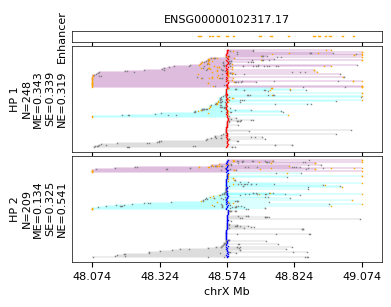

In [167]:
# Plot Multiway Enhancer model
FigRow, FigCol = 3, 1
fig, Axs = plt.subplots(FigRow, FigCol, figsize=(4,  3),
                        gridspec_kw={'height_ratios': [5, 47.5, 47.5]}, 
                        sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.05)
print(Pro_dict[ProID] - res_region*0.5, Pro_dict[ProID] + res_region*0.5)
# Promoter and Enhancer 
for index, rowdf in en_fbed.iterrows():
    start, end = rowdf["start"], rowdf["end"]
    ID = rowdf["ID"]
    xs, ys = [start, end], [1, 1]
    Axs[0].plot(xs, ys, c="orange", linewidth=1)
Axs[0].set_yticks([])
Axs[0].set_ylabel("Enhancer", fontsize=8)

for HP, gdf in plot_df.groupby("HP"):
    gdf = gdf.sort_values(by=["ETypeNum", "start"]).reset_index(drop=True)
    HPreads = gdf.rID.unique()
    HrCount = len(HPreads) 
    yN = 0
    for rID in HPreads:
        P = gdf.rID == rID
        aread_df = gdf.loc[P, :]
        rstart, rend = aread_df.start.min(), aread_df.end.max()
        if rstart <= Pro_dict[ProID] - res_region*0.5:
            rstart = Pro_dict[ProID] - res_region*0.5
        if rend >= Pro_dict[ProID] + res_region*0.5:
            rend = Pro_dict[ProID] + res_region*0.5
        xs, ys = [rstart, rend], [yN, yN]
        if aread_df.EType.values[0] == "SE":
            sc = "cyan"
        elif  aread_df.EType.values[0] == "ME":
            sc = "purple"
        else:
            sc = "grey"
        Axs[HP].plot(xs, ys, c=sc, linewidth=0.2, alpha = 1)
        
        for index, rowdf in aread_df.iterrows():
            if rowdf["PID"] == ProID :
                if HP == 1:
                    sc = "red"
                else:
                    sc = "blue"
                if rowdf["EID"] != ".":
                    overlap_en = rowdf["EID"]
            #elif "en" in rowdf["EID"] and rowdf["EID"] != overlap_en and aread_df.EType.values[0] != "NE":
            elif "en" in rowdf["EID"] and aread_df.EType.values[0] != "NE":
                sc = "orange"
            else:
                sc = "grey"
            Axs[HP].plot(rowdf["pos"], yN, marker="s", c=sc, markersize=1)
        yN += 1

    Axs[HP].set_xticks([])
    Axs[HP].set_yticks([])
    # Multiway Enhancer ratio
    MEratio = pivot_df.loc[ProID, f"{HP}_ME_ratio"]
    SEratio = pivot_df.loc[ProID, f"{HP}_SE_ratio"]
    Axs[HP].set_ylabel( "HP %d\nN=%d\nME=%.3f\nSE=%.3f\nNE=%.3f"%(HP, HPreadcount[HP], MEratio, SEratio, 1-MEratio-SEratio), fontsize=8 )

xS, xE = Pro_dict[ProID] - res_region //2, Pro_dict[ProID]+ res_region //2 
plt.xlim([xS-1.5*flank, xE+1.5*flank])
# xticks
Xtick = list( np.linspace(xS, xE, 5 ,endpoint=True) )
Xtick_label = [ "%.3f"%(i/10**6) for i in Xtick ]
plt.xticks( Xtick, Xtick_label)
plt.xlabel("%s Mb"%(region[0] ) )
Axs[0].set_title(ProID, fontsize=8)
#plt.show()
plt.savefig(f"{outdir}/ME_interaction_line_plot_{ProID}.pdf")

In [164]:
# Enhancer interaction Plot 
## UBA1 ENSG00000130985.16 VGLL1  ENSG00000102243.12
# CTPS2 ENSG00000047230.14
res_region = 1000000
flank =  0.05*res_region
ProID = "ENSG00000047230.14"
Eread_dict = Ereads_df.set_index('rID').to_dict()["EType"]
rIDs = int_df.loc[int_df.PID ==ProID, "rID"].unique()
plot_df = int_df.loc[int_df.rID.isin(rIDs), :].copy()
plot_df["pos"] = ( plot_df.start + plot_df.end)//2
plot_df["EType"] = plot_df.rID.apply( lambda x: Eread_dict[x] )
ETypedict = {"NE":0, "SE":1, "ME":2}
plot_df["ETypeNum"] = plot_df["EType"].apply(lambda x: ETypedict[x])
## Hp readscount
h1reads, h2reads = plot_df.loc[plot_df.HP==1, "rID"].unique(), plot_df.loc[plot_df.HP==2, "rID"].unique() 
HPreadcount = {1:len(h1reads),
               2:len(h2reads)}
## enhancer fragment out of regions
P1 =  (plot_df["pos"]  >  Pro_dict[ProID] + res_region*0.5) * (plot_df["EID"]!= ".")
plot_df.loc[P1, "pos"] = Pro_dict[ProID] + res_region*0.5
P2 =  (plot_df["pos"]  < Pro_dict[ProID] - res_region*0.5) * (plot_df["EID"]!= ".")
plot_df.loc[P2, "pos"] = Pro_dict[ProID] - res_region*0.5
## filter out other fragments not in regions
Pres = ( plot_df["pos"] - Pro_dict[ProID] ).abs() <=  res_region //2 # regtrition region fragments
plot_df = plot_df.loc[Pres, :]

## remove Unknow Etype
Unreads = plot_df.loc[plot_df.EType!="Un", "rID"].unique()
plot_df = plot_df.loc[ plot_df.rID.isin(Unreads), :].reset_index()

# # Subsampling
select_reads = Subsampling(h1reads, 100)
select_reads.extend( Subsampling(h2reads, 100) )
plot_df = plot_df.loc[ plot_df.rID.isin(select_reads), :].reset_index()

## filter region  enhancers
en_bed["pos"] = ( en_bed.start + en_bed.end ) // 2
P = ( en_bed["pos"] - Pro_dict[ProID] ).abs() <=  res_region //2 
en_fbed = en_bed.loc[P,:].reset_index() # regtrition region enhancer

16212936.0 17212936.0


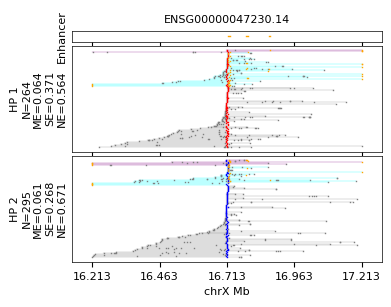

In [165]:
# Plot Multiway Enhancer model
FigRow, FigCol = 3, 1
fig, Axs = plt.subplots(FigRow, FigCol, figsize=(4,  3),
                        gridspec_kw={'height_ratios': [5, 47.5, 47.5]}, 
                        sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.05)
print(Pro_dict[ProID] - res_region*0.5, Pro_dict[ProID] + res_region*0.5)
# Promoter and Enhancer 
for index, rowdf in en_fbed.iterrows():
    start, end = rowdf["start"], rowdf["end"]
    ID = rowdf["ID"]
    xs, ys = [start, end], [1, 1]
    Axs[0].plot(xs, ys, c="orange", linewidth=1)
Axs[0].set_yticks([])
Axs[0].set_ylabel("Enhancer", fontsize=8)

for HP, gdf in plot_df.groupby("HP"):
    gdf = gdf.sort_values(by=["ETypeNum", "start"]).reset_index(drop=True)
    HPreads = gdf.rID.unique()
    HrCount = len(HPreads) 
    yN = 0
    for rID in HPreads:
        P = gdf.rID == rID
        aread_df = gdf.loc[P, :]
        rstart, rend = aread_df.start.min(), aread_df.end.max()
        if rstart <= Pro_dict[ProID] - res_region*0.5:
            rstart = Pro_dict[ProID] - res_region*0.5
        if rend >= Pro_dict[ProID] + res_region*0.5:
            rend = Pro_dict[ProID] + res_region*0.5
        xs, ys = [rstart, rend], [yN, yN]
        if aread_df.EType.values[0] == "SE":
            sc = "cyan"
        elif  aread_df.EType.values[0] == "ME":
            sc = "purple"
        else:
            sc = "grey"
        Axs[HP].plot(xs, ys, c=sc, linewidth=0.2, alpha = 1)
        
        for index, rowdf in aread_df.iterrows():
            if rowdf["PID"] == ProID :
                if HP == 1:
                    sc = "red"
                else:
                    sc = "blue"
                if rowdf["EID"] != ".":
                    overlap_en = rowdf["EID"]
            elif "en" in rowdf["EID"] and aread_df.EType.values[0] != "NE":
                sc = "orange"
            else:
                sc = "grey"
            Axs[HP].plot(rowdf["pos"], yN, marker="s", c=sc, markersize=1)
        yN += 1

    Axs[HP].set_xticks([])
    Axs[HP].set_yticks([])
    # Multiway Enhancer ratio
    MEratio = pivot_df.loc[ProID, f"{HP}_ME_ratio"]
    SEratio = pivot_df.loc[ProID, f"{HP}_SE_ratio"]
    Axs[HP].set_ylabel( "HP %d\nN=%d\nME=%.3f\nSE=%.3f\nNE=%.3f"%(HP, HPreadcount[HP], MEratio, SEratio, 1-MEratio-SEratio), fontsize=8 )

xS, xE = Pro_dict[ProID] - res_region //2, Pro_dict[ProID]+ res_region //2 
plt.xlim([xS-1.5*flank, xE+1.5*flank])
# xticks
Xtick = list( np.linspace(xS, xE, 5 ,endpoint=True) )
Xtick_label = [ "%.3f"%(i/10**6) for i in Xtick ]
plt.xticks( Xtick, Xtick_label)
plt.xlabel("%s Mb"%(region[0] ) )
Axs[0].set_title(ProID, fontsize=8)
#plt.show()
plt.savefig(f"{outdir}/ME_interaction_line_plot_{ProID}.pdf")